# Group DRO


In [1]:
import os

import numpy as np
from PIL import Image

import random
import copy

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils
from torch.utils.data import DataLoader, random_split



## Prepare the colored MNIST dataset
Take data similarly to HW1, but split into 4 groups by color and label:
* "red1"
* "red0"
* "nonRed1"
* "nonRed0"

Then construct two datasets, one with spurious correlation between color and label and one without.

In [2]:
def color_grayscale_arr(arr, red=True, nonRed='green'):
  """Converts grayscale image to either red or green"""
  assert arr.ndim == 2
  dtype = arr.dtype
  h, w = arr.shape
  arr = np.reshape(arr, [h, w, 1])
  if red:
    arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)], axis=2)
    return arr
  elif nonRed=='green':
    arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
  elif nonRed=='blue':
    arr = np.concatenate([np.zeros((h, w, 2),dtype=dtype),
                          arr], axis=2)
  else:
    arr=np.concatenate([arr,arr,arr], axis=2)
    
    for i in range(h):
        for j in range(w):
            if not arr[i,j,0]==0:
                col=np.random.uniform(0,253,3)
                arr[i,j,:]=col
                 
  return arr


class ColoredMNIST(datasets.VisionDataset):
  """
  Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

  Args:
    sampleSize (int between 1 and 60000): number of samples in this dataset
    startFrom (int between 0 and 60000-sampleSize): start index of sample
    flipLabel (float between 0 and 1): probability of flipping the label
    flipColor (float between 0 and 1): probability of flipping the color
    nonRed (string, one of 'green', 'blue', 'random'): nonRed color
    colorLabel (boolean): whether the dataset contains colorLabel
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """
  def __init__(self, sampleSize=60000, startFrom=0, flipLabel=0.25, flipColor=0.2, nonRed='green', colorLabel=True, 
               root='./data', transform=None, target_transform=None):
    super(ColoredMNIST, self).__init__(root, transform=transform,
                                target_transform=target_transform)
    assert 1<=sampleSize<=60000 and 0<=flipLabel<=1 and 0<=flipColor<=1 and nonRed in ['green','blue','random']
    
    self.colorLabel = colorLabel
    
    self.prepare_colored_mnist(flipLabel,flipColor,sampleSize,startFrom,nonRed)

    self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 
                                   'FL{}FC{}SS{}CL{}.pt'.format(flipLabel, flipColor,sampleSize,nonRed)))


  def __getitem__(self, index):
    """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
    
    img, target, color = self.data_label_tuples[index]

    if self.transform is not None:
      img = self.transform(img)

    if self.target_transform is not None:
      target = self.target_transform(target)

    return (img, target, color) if self.colorLabel else (img, target)

  def __len__(self):
    return len(self.data_label_tuples)

  def prepare_colored_mnist(self,flipLabel,flipColor,sampleSize,startFrom,nonRed):
    colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
    if os.path.exists(os.path.join(colored_mnist_dir, 
                                   'FL{}FC{}SS{}CL{}.pt'.format(flipLabel,flipColor,sampleSize,nonRed))): 
        #specific flipLabel, flipColor, SampleSize
      print('Colored MNIST dataset already exists')
      return

    print('Preparing Colored MNIST')
    train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)
    
    data=[]
    sample=set(range(startFrom,startFrom+sampleSize))
    
    for idx, (im, label) in enumerate(train_mnist):
      #Only take first (sampleSize) images
      if idx not in sample:
            continue
      
      if idx % 10000 == 0:
        print(f'Converting image {idx-startFrom}/{sampleSize}')
      im_array = np.array(im)

      # Assign a binary label y to the image based on the digit
      binary_label = 0 if label < 5 else 1

      # Flip label with (flipLabel) probability
      if np.random.uniform() < flipLabel:
        binary_label = binary_label ^ 1

      # Color the image either red or green according to its possibly flipped label
      color_red = binary_label == 0

      # Flip the color with a probability (flipColor) that depends on the environment
      if np.random.uniform() < flipColor:
          color_red = not color_red

      colored_arr = color_grayscale_arr(im_array, color_red, nonRed)

      data.append((Image.fromarray(colored_arr), binary_label, int(color_red)))
      # Debug
      # print('original label', type(label), label)
      # print('binary label', binary_label)
      # print('assigned color', 'red' if color_red else 'green')
      # plt.imshow(colored_arr)
      # plt.show()
      # break
    
    if not os.path.exists(colored_mnist_dir):
      os.makedirs(colored_mnist_dir)
    torch.save(data, os.path.join(colored_mnist_dir, 'FL{}FC{}SS{}CL{}.pt'.format(flipLabel,flipColor,sampleSize,nonRed)))
    
    
    
    

In [3]:
def plot_dataset_digits(dataset): 
  fig = plt.figure(figsize=(13, 8))
  columns = 6
  rows = 3
  # ax enables access to manipulate each of subplots
  ax = []
  isColor = True if len(dataset[0]) == 3 else False  #isColor: whether the dataset contains colorLabel

  for i in range(columns * rows):
    if isColor:
        img, label, color = dataset[i]
    else:
        img, label = dataset[i]
    # create subplot and append to ax
    ax.append(fig.add_subplot(rows, columns, i + 1))
    ax[-1].set_title("Label: " + str(label))  # set title
    plt.imshow(img)

  plt.show()  # finally, render the plot

In [4]:
#Devide dataset in groups
def datasetInGroups(dataset):
    groupName=['red1','red0','nonRed1','nonRed0']
    datasetG={gn:[] for gn in groupName}
    count = 0
    for img, tar, col in dataset:
        if tar==1 and col==1:
            datasetG['red1'].append((img,tar))
        elif tar==0 and col==1:
            datasetG['red0'].append((img,tar))
        elif tar==1 and col==0:
            datasetG['nonRed1'].append((img,tar))
        else:
            datasetG['nonRed0'].append((img,tar))
        count += 1
        if count%10000==0:
            print("Converting images {}".format(count))
        
    return datasetG

### Training data (spurious correlation)

Plot:

Preparing Colored MNIST


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Converting image 0/20000
Converting image 10000/20000


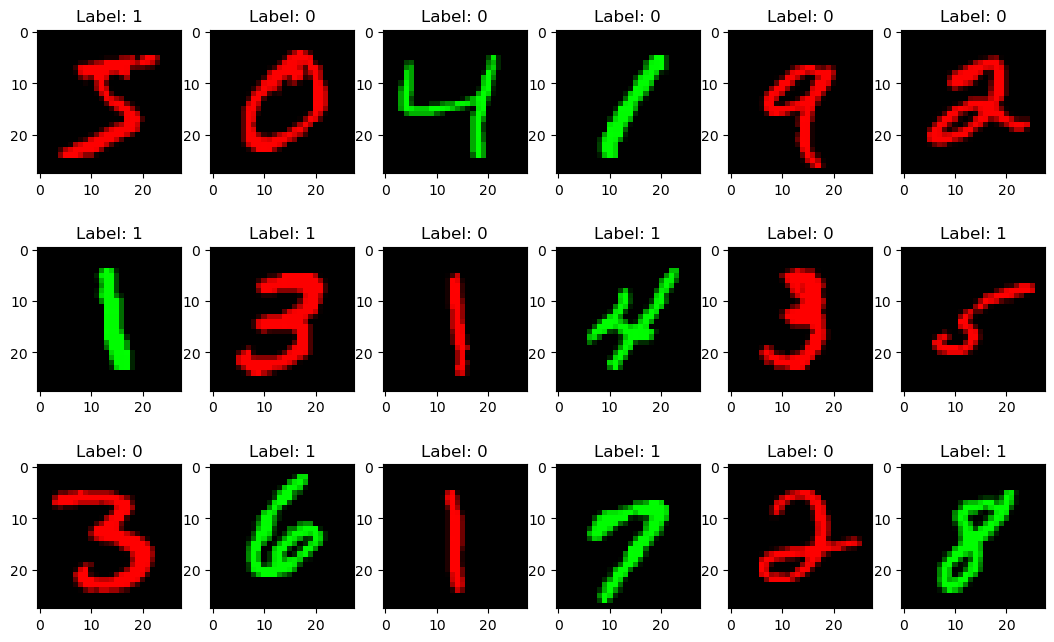

In [5]:
dataset=ColoredMNIST(sampleSize=20000)
plot_dataset_digits(dataset)

In [6]:
dataset = ColoredMNIST(sampleSize=20000, root='./data',    
    transform=transforms.ToTensor(),
    target_transform = lambda tar: torch.tensor([float(tar)]))

Colored MNIST dataset already exists


In [7]:
datasetG=datasetInGroups(dataset)
for d in datasetG:
    print(d,len(datasetG[d]))

Converting images 10000
Converting images 20000
red1 1975
red0 8136
nonRed1 7821
nonRed0 2068


### Test Data

Plot:

Preparing Colored MNIST
Converting image 0/5000


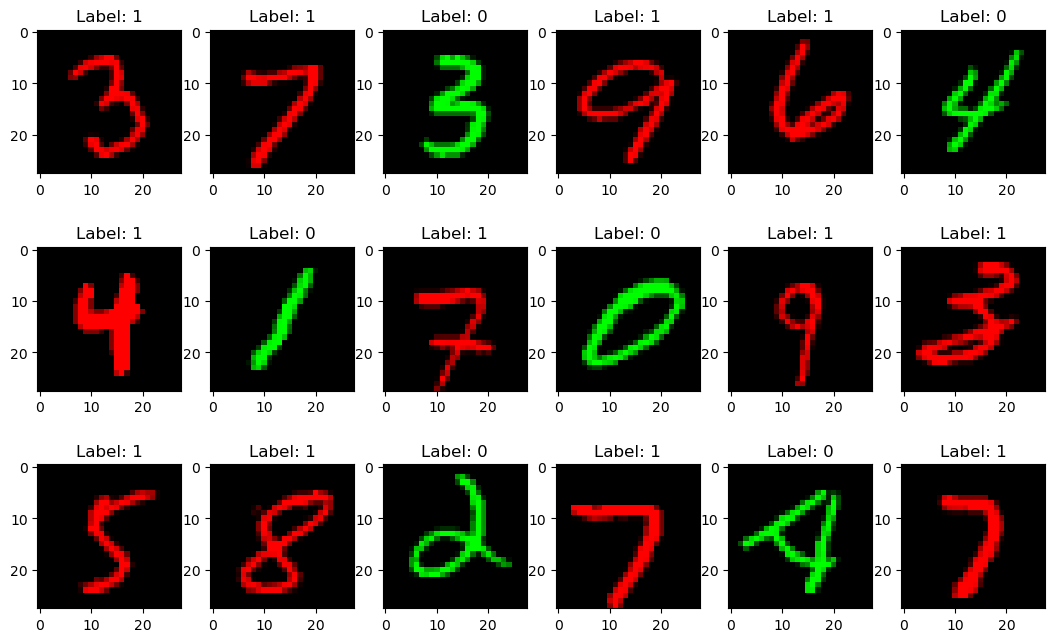

In [8]:
test1=ColoredMNIST(sampleSize=5000,startFrom=30000,flipColor=.9)
plot_dataset_digits(test1)

In [9]:
test1 = ColoredMNIST(sampleSize=5000,flipColor=.9,startFrom=30000,
    transform=transforms.ToTensor(),
    target_transform = lambda tar: torch.tensor([float(tar)]))
test1G=datasetInGroups(test1)
for d in test1G:
    print(d,len(test1G[d]))

Colored MNIST dataset already exists
red1 2242
red0 247
nonRed1 225
nonRed0 2286


## Model Class and Train Functions

In [10]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4 * 4 * 50, 500)
    self.fc2 = nn.Linear(500, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4 * 4 * 50)
    x = F.relu(self.fc1(x))
    logits = self.fc2(x).flatten()
    return logits

In [11]:
def trainERM(data, batch_size, l2_lambd=.001, etaT=0.001, isModelList=True, storeModel=100):
  modelList=[]

  #use_cuda = torch.cuda.is_available()
  use_cuda = False # just putting things on the cpu for now
  device = "cpu"
  #device = torch.device("cuda" if use_cuda else "cpu")

  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

  train_loader = torch.utils.data.DataLoader(data,
    batch_size=batch_size, shuffle=True, **kwargs)

  model = ConvNet()
  optimizer = optim.Adam(model.parameters(), lr=etaT)

  model.train()
  for batch_idx, (data, target, _) in enumerate(train_loader):
    data, target = data.to(device), target.to(device).float()
    optimizer.zero_grad()
    output = model(data)
    length = len(target)
    loss = F.binary_cross_entropy_with_logits(output, np.reshape(target, length)) # from a 64x1 to just 64
    l2_norm = sum(p.pow(2).sum() for p in model.parameters())
    loss += l2_lambd * l2_norm

    loss.backward()
    optimizer.step()

    if isModelList and (batch_idx+1) % storeModel == 0:
        modelList.append(copy.deepcopy(model))

    if batch_idx % 10 == 0:
      print('Training ERM: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        batch_idx * len(data), len(train_loader.dataset),
               100. * batch_idx / len(train_loader), loss.item()))
      
  return modelList if isModelList else model


For DRO:

In [12]:
def train(datasetG,T,l2_lambd=.001, etaq=.001,etaT=.001,isModelList=True, storeModel = 200):
    model = ConvNet()
    optimizer = optim.Adam(model.parameters(), lr=etaT)
    modelList=[]
    groupName=['red1','red0','nonRed1','nonRed0']
    q = np.repeat(1/4,4)
    for t in range(T):
        optimizer.zero_grad()
        
        #Choose a random group
        groupIndex = random.sample(range(4),1)[0]
        group = groupName[groupIndex]
        
        #Sample one data point from the group
        img, tar = random.sample(datasetG[group],1)[0]
        
        output = model(img)
        
        #L2 regularization loss
        loss = F.binary_cross_entropy_with_logits(output,tar)
        l2_norm = sum(p.pow(2).sum() for p in model.parameters())
        loss += l2_lambd * l2_norm
        
        #Update q
        lossNP = loss.detach().numpy()
        q[groupIndex] = q[groupIndex] * np.exp(etaq*lossNP)
        q /= q.sum()
        
        #Update theta
        for g in optimizer.param_groups:
            g['lr'] = etaT * q[groupIndex] #Change learning rate
        loss.backward()
        optimizer.step()

        
        if isModelList and (t+1)%storeModel==0:
            modelList.append(copy.deepcopy(model))
        if (t+1)%5000 == 0:
            print('Processing {}/{} loops'.format(t+1,T))
        
    
    return modelList if isModelList else model
        

Accuracy Helper Functions:

In [13]:
def accuracy(model,datasetG,accDic):
    for gn, d in datasetG.items():
        a=0
        for img, tar in d:
            pred = torch.where(torch.gt(model(img), torch.Tensor([0.0])),
                         torch.Tensor([1.0]),
                         torch.Tensor([0.0]))
            a+=1 if pred == tar else 0
        accDic[gn].append(a/len(d))
    return accDic

def ModelListAccuracy(modelList, datasetG):
    groupName=['red1','red0','nonRed1','nonRed0']
    accDic={gn:[] for gn in groupName}
    for idx, model in enumerate(modelList):
        accDic = accuracy(model,datasetG,accDic)
        print('Processing model {} / {}'.format(idx+1,len(modelList)))  if (idx+1)%10 == 0 else 1
    return accDic
            

In [14]:
def averageAccuracy(groupedAccuracy,datasetG):

    groupName=['red1','red0','nonRed1','nonRed0']
    AvgAcc = np.repeat(0,len(groupedAccuracy['red1']))
    total = 0
    for gn in groupName:
        AvgAcc = AvgAcc + np.array(groupedAccuracy[gn])*len(datasetG[gn])
        total += len(datasetG[gn])
    AvgAcc /= total
    return AvgAcc



In [15]:
def FinalAccuracy(groupedAccuracy,dataset):
    groupName= ['red1', 'red0', 'nonRed1', 'nonRed0']
    final={}
    for gn in groupName:
        final[gn] = groupedAccuracy[gn][-1]
    final['WorstAcc'] = min(final.values())
    final['AvgAcc'] = averageAccuracy(groupedAccuracy, datasetG)[-1]
    return final

## Baseline ERM (no regularization)


In [16]:
model_list_erm=trainERM(dataset, 64, l2_lambd=0, storeModel=3)

Training ERM: [0/20000 (0%)]	Loss: 0.690525
Training ERM: [640/20000 (3%)]	Loss: 0.449809
Training ERM: [1280/20000 (6%)]	Loss: 0.477968
Training ERM: [1920/20000 (10%)]	Loss: 0.462054
Training ERM: [2560/20000 (13%)]	Loss: 0.403858
Training ERM: [3200/20000 (16%)]	Loss: 0.526059
Training ERM: [3840/20000 (19%)]	Loss: 0.580358
Training ERM: [4480/20000 (22%)]	Loss: 0.533840
Training ERM: [5120/20000 (26%)]	Loss: 0.521685
Training ERM: [5760/20000 (29%)]	Loss: 0.508563
Training ERM: [6400/20000 (32%)]	Loss: 0.479198
Training ERM: [7040/20000 (35%)]	Loss: 0.409382
Training ERM: [7680/20000 (38%)]	Loss: 0.453496
Training ERM: [8320/20000 (42%)]	Loss: 0.585125
Training ERM: [8960/20000 (45%)]	Loss: 0.393098
Training ERM: [9600/20000 (48%)]	Loss: 0.528221
Training ERM: [10240/20000 (51%)]	Loss: 0.497071
Training ERM: [10880/20000 (54%)]	Loss: 0.492238
Training ERM: [11520/20000 (58%)]	Loss: 0.511633
Training ERM: [12160/20000 (61%)]	Loss: 0.377935
Training ERM: [12800/20000 (64%)]	Loss: 0.4

In [17]:
len(model_list_erm)

104

In [18]:
train_accuracy_erm = ModelListAccuracy(model_list_erm, datasetG)


Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


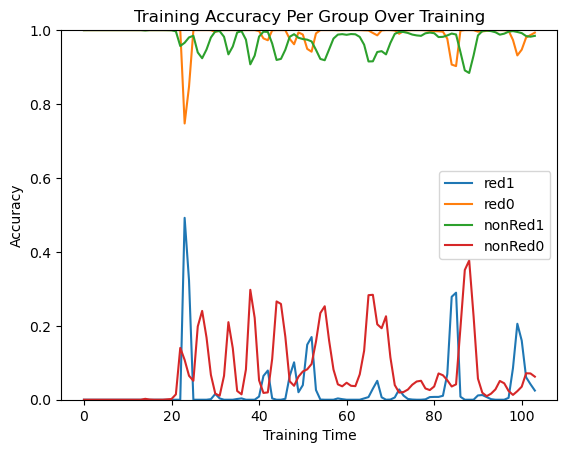

In [19]:
plt.plot(train_accuracy_erm['red1'],label='red1')
plt.plot(train_accuracy_erm['red0'],label='red0')
plt.plot(train_accuracy_erm['nonRed1'],label='nonRed1')
plt.plot(train_accuracy_erm['nonRed0'],label='nonRed0')
plt.title('Training Accuracy Per Group Over Training')
plt.ylabel("Accuracy")
plt.xlabel("Training Time")
plt.ylim([0, 1])
plt.ylim([0, 1])
plt.legend()

Text(0.5, 0, 'Training Time')

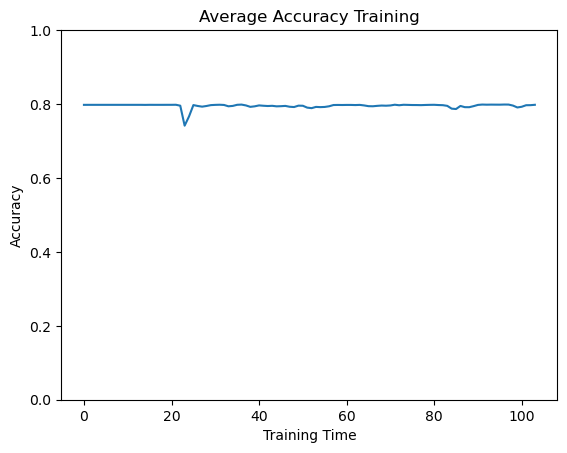

In [20]:
plt.plot(averageAccuracy(train_accuracy_erm,datasetG))
plt.ylim([0, 1])
plt.title("Average Accuracy Training")
plt.ylabel("Accuracy")
plt.xlabel("Training Time")

In [21]:
test_accuracy_erm = ModelListAccuracy(model_list_erm, test1G)


Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


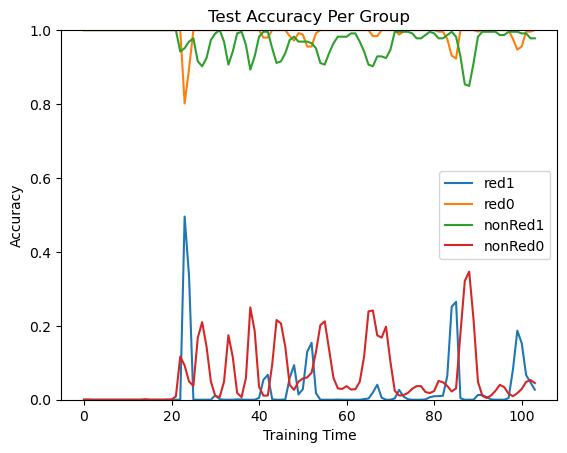

In [22]:
plt.plot(test_accuracy_erm['red1'],label='red1')
plt.plot(test_accuracy_erm['red0'],label='red0')
plt.plot(test_accuracy_erm['nonRed1'],label='nonRed1')
plt.plot(test_accuracy_erm['nonRed0'],label='nonRed0')
plt.title("Test Accuracy Per Group")
plt.ylabel("Accuracy")
plt.xlabel("Training Time")
plt.ylim([0, 1])
plt.legend()

Text(0.5, 1.0, 'Average Accuracy Test')

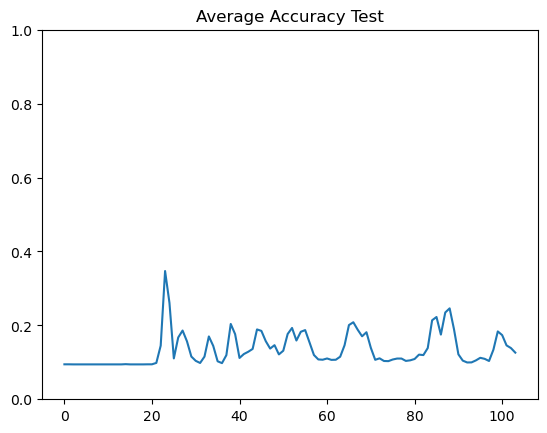

In [23]:
plt.plot(averageAccuracy(test_accuracy_erm,test1G))
plt.ylim([0, 1])
plt.title("Average Accuracy Test")

### Result Summary

In [24]:

print("ERM Train Accuracy Final:", round(averageAccuracy(train_accuracy_erm, datasetG)[-1], 4) * 100, "%")
print("ERM Train Accuracy Final red0:", round(train_accuracy_erm['red0'][-1], 4) * 100, "%")
print("ERM Train Accuracy Final red1:", round(train_accuracy_erm['red1'][-1], 4) * 100, "%")
print("ERM Train Accuracy Final nonRed0:", round(train_accuracy_erm['nonRed0'][-1], 4) * 100, "%")
print("ERM Train Accuracy Final nonRed1:", round(train_accuracy_erm['nonRed1'][-1], 4) * 100, "%")

print("\n")

print("ERM Test Accuracy Final:", round(averageAccuracy(test_accuracy_erm, test1G)[-1], 4) * 100, "%")
print("ERM Test Accuracy Final red0:", round(test_accuracy_erm['red0'][-1], 4) * 100, "%")
print("ERM Test Accuracy Final red1:", round(test_accuracy_erm['red1'][-1], 4) * 100, "%")
print("ERM Test Accuracy Final nonRed0:", round(test_accuracy_erm['nonRed0'][-1], 4) * 100, "%")
print("ERM Test Accuracy Final nonRed1:", round(test_accuracy_erm['nonRed1'][-1], 4) * 100, "%")


ERM Train Accuracy Final: 79.80000000000001 %
ERM Train Accuracy Final red0: 99.32 %
ERM Train Accuracy Final red1: 2.48 %
ERM Train Accuracy Final nonRed0: 6.239999999999999 %
ERM Train Accuracy Final nonRed1: 98.45 %


ERM Test Accuracy Final: 12.620000000000001 %
ERM Test Accuracy Final red0: 100.0 %
ERM Test Accuracy Final red1: 2.7199999999999998 %
ERM Test Accuracy Final nonRed0: 4.51 %
ERM Test Accuracy Final nonRed1: 97.78 %


In [25]:
FinalAccuracy(train_accuracy_erm, datasetG)

{'red1': 0.02481012658227848,
 'red0': 0.9932399213372665,
 'nonRed1': 0.9845288326300985,
 'nonRed0': 0.062379110251450674,
 'WorstAcc': 0.02481012658227848,
 'AvgAcc': 0.79795}

In [26]:
FinalAccuracy(test_accuracy_erm, test1G)

{'red1': 0.027207850133809098,
 'red0': 1.0,
 'nonRed1': 0.9777777777777777,
 'nonRed0': 0.04505686789151356,
 'WorstAcc': 0.027207850133809098,
 'AvgAcc': 0.7965056553406961}

## ERM (regularization)


In [27]:
model_list_erm_reg=trainERM(dataset, 64, l2_lambd=0.001, storeModel=3)

Training ERM: [0/20000 (0%)]	Loss: 0.893621
Training ERM: [640/20000 (3%)]	Loss: 0.727079
Training ERM: [1280/20000 (6%)]	Loss: 0.750694
Training ERM: [1920/20000 (10%)]	Loss: 0.739507
Training ERM: [2560/20000 (13%)]	Loss: 0.519877
Training ERM: [3200/20000 (16%)]	Loss: 0.563576
Training ERM: [3840/20000 (19%)]	Loss: 0.587346
Training ERM: [4480/20000 (22%)]	Loss: 0.525865
Training ERM: [5120/20000 (26%)]	Loss: 0.441303
Training ERM: [5760/20000 (29%)]	Loss: 0.555554
Training ERM: [6400/20000 (32%)]	Loss: 0.410451
Training ERM: [7040/20000 (35%)]	Loss: 0.501762
Training ERM: [7680/20000 (38%)]	Loss: 0.478247
Training ERM: [8320/20000 (42%)]	Loss: 0.534416
Training ERM: [8960/20000 (45%)]	Loss: 0.407411
Training ERM: [9600/20000 (48%)]	Loss: 0.568614
Training ERM: [10240/20000 (51%)]	Loss: 0.508264
Training ERM: [10880/20000 (54%)]	Loss: 0.515109
Training ERM: [11520/20000 (58%)]	Loss: 0.453826
Training ERM: [12160/20000 (61%)]	Loss: 0.651833
Training ERM: [12800/20000 (64%)]	Loss: 0.5

In [28]:
train_accuracy_erm_reg = ModelListAccuracy(model_list_erm_reg, datasetG)


Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


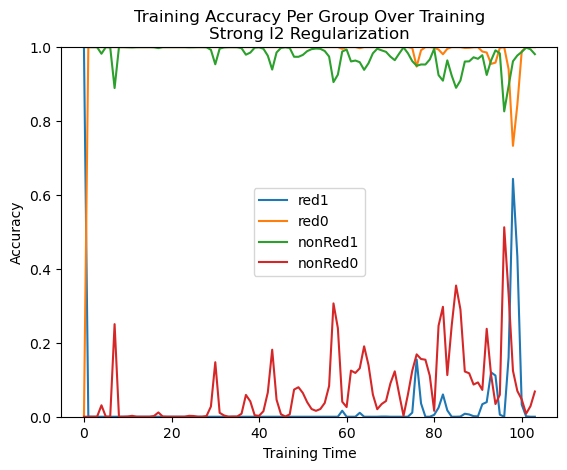

In [29]:
plt.plot(train_accuracy_erm_reg['red1'],label='red1')
plt.plot(train_accuracy_erm_reg['red0'],label='red0')
plt.plot(train_accuracy_erm_reg['nonRed1'],label='nonRed1')
plt.plot(train_accuracy_erm_reg['nonRed0'],label='nonRed0')
plt.title('Training Accuracy Per Group Over Training\nStrong l2 Regularization')
plt.ylabel("Accuracy")
plt.xlabel("Training Time")
plt.ylim([0, 1])
plt.ylim([0, 1])
plt.legend()

Text(0.5, 0, 'Training Time')

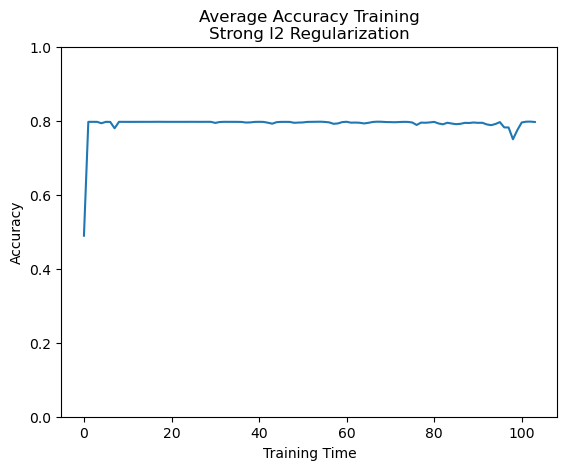

In [30]:
plt.plot(averageAccuracy(train_accuracy_erm_reg,datasetG))
plt.ylim([0, 1])
plt.title("Average Accuracy Training\nStrong l2 Regularization")
plt.ylabel("Accuracy")
plt.xlabel("Training Time")

In [31]:
test_accuracy_erm_reg = ModelListAccuracy(model_list_erm_reg, test1G)

Processing model 10 / 104
Processing model 20 / 104
Processing model 30 / 104
Processing model 40 / 104
Processing model 50 / 104
Processing model 60 / 104
Processing model 70 / 104
Processing model 80 / 104
Processing model 90 / 104
Processing model 100 / 104


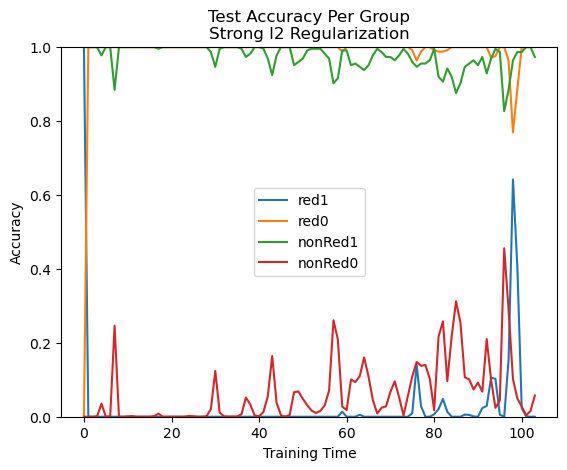

In [32]:
plt.plot(test_accuracy_erm_reg['red1'],label='red1')
plt.plot(test_accuracy_erm_reg['red0'],label='red0')
plt.plot(test_accuracy_erm_reg['nonRed1'],label='nonRed1')
plt.plot(test_accuracy_erm_reg['nonRed0'],label='nonRed0')
plt.title("Test Accuracy Per Group\nStrong l2 Regularization")
plt.ylabel("Accuracy")
plt.xlabel("Training Time")
plt.ylim([0, 1])
plt.legend()

Text(0.5, 1.0, 'Average Accuracy Test\nStrong l2 Regularization')

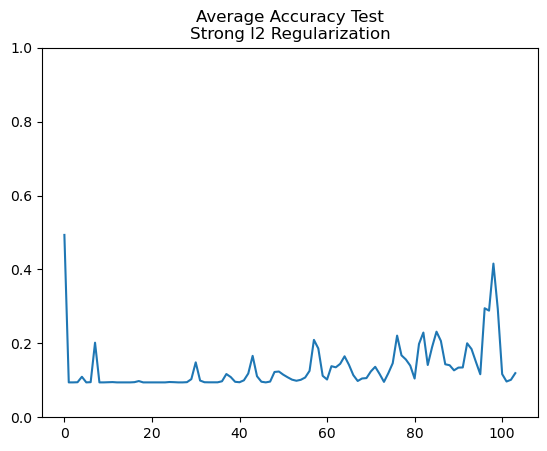

In [33]:
plt.plot(averageAccuracy(test_accuracy_erm_reg,test1G))
plt.ylim([0, 1])
plt.title("Average Accuracy Test\nStrong l2 Regularization")

### Result Summary

In [34]:
FinalAccuracy(train_accuracy_erm_reg, datasetG)

{'red1': 0.0,
 'red0': 0.9998770894788593,
 'nonRed1': 0.9809487277841709,
 'nonRed0': 0.06818181818181818,
 'WorstAcc': 0.0,
 'AvgAcc': 0.7974}

In [35]:
FinalAccuracy(test_accuracy_erm_reg, test1G)

{'red1': 0.0,
 'red0': 1.0,
 'nonRed1': 0.9733333333333334,
 'nonRed0': 0.05730533683289589,
 'WorstAcc': 0.0,
 'AvgAcc': 0.7933473718285216}

## DRO (With regularization)

In [64]:
modelList=train(datasetG,250000, storeModel=2500)

Processing 5000/250000 loops
Processing 10000/250000 loops
Processing 15000/250000 loops
Processing 20000/250000 loops
Processing 25000/250000 loops
Processing 30000/250000 loops
Processing 35000/250000 loops
Processing 40000/250000 loops
Processing 45000/250000 loops
Processing 50000/250000 loops
Processing 55000/250000 loops
Processing 60000/250000 loops
Processing 65000/250000 loops
Processing 70000/250000 loops
Processing 75000/250000 loops
Processing 80000/250000 loops
Processing 85000/250000 loops
Processing 90000/250000 loops
Processing 95000/250000 loops
Processing 100000/250000 loops
Processing 105000/250000 loops
Processing 110000/250000 loops
Processing 115000/250000 loops
Processing 120000/250000 loops
Processing 125000/250000 loops
Processing 130000/250000 loops
Processing 135000/250000 loops
Processing 140000/250000 loops
Processing 145000/250000 loops
Processing 150000/250000 loops
Processing 155000/250000 loops
Processing 160000/250000 loops
Processing 165000/250000 loo

In [65]:
len(modelList)

100

In [66]:
TrainAcc = ModelListAccuracy(modelList, datasetG)

Processing model 10 / 100
Processing model 20 / 100
Processing model 30 / 100
Processing model 40 / 100
Processing model 50 / 100
Processing model 60 / 100
Processing model 70 / 100
Processing model 80 / 100
Processing model 90 / 100
Processing model 100 / 100


In [67]:
TrainAcc 

{'red1': [0.7731645569620254,
  0.6435443037974684,
  0.8516455696202532,
  0.7210126582278481,
  0.7093670886075949,
  0.6688607594936709,
  0.8212658227848101,
  0.789367088607595,
  0.7341772151898734,
  0.7179746835443038,
  0.6850632911392405,
  0.7265822784810126,
  0.7088607594936709,
  0.6688607594936709,
  0.7432911392405064,
  0.660253164556962,
  0.68,
  0.690126582278481,
  0.650126582278481,
  0.72,
  0.7058227848101266,
  0.7225316455696202,
  0.6982278481012658,
  0.7048101265822785,
  0.6217721518987341,
  0.7032911392405063,
  0.6946835443037974,
  0.6794936708860759,
  0.6749367088607595,
  0.7169620253164557,
  0.6921518987341773,
  0.7078481012658228,
  0.7154430379746836,
  0.7134177215189873,
  0.7154430379746836,
  0.6506329113924051,
  0.7270886075949367,
  0.6678481012658228,
  0.7655696202531646,
  0.7073417721518988,
  0.7179746835443038,
  0.6992405063291139,
  0.6982278481012658,
  0.690126582278481,
  0.7488607594936709,
  0.6946835443037974,
  0.766075949

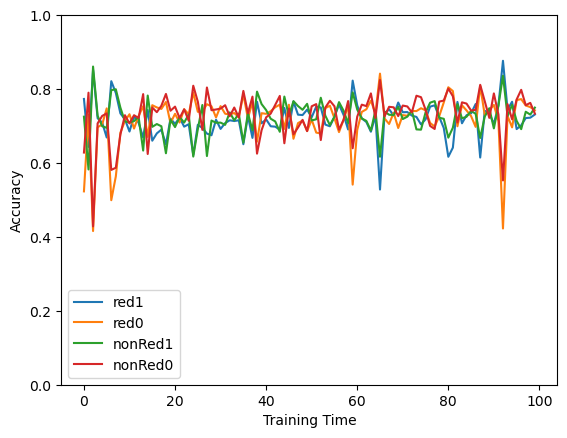

In [68]:
plt.plot(TrainAcc['red1'],label='red1')
plt.plot(TrainAcc['red0'],label='red0')
plt.plot(TrainAcc['nonRed1'],label='nonRed1')
plt.plot(TrainAcc['nonRed0'],label='nonRed0')
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")
plt.legend()

Text(0, 0.5, 'Accuracy')

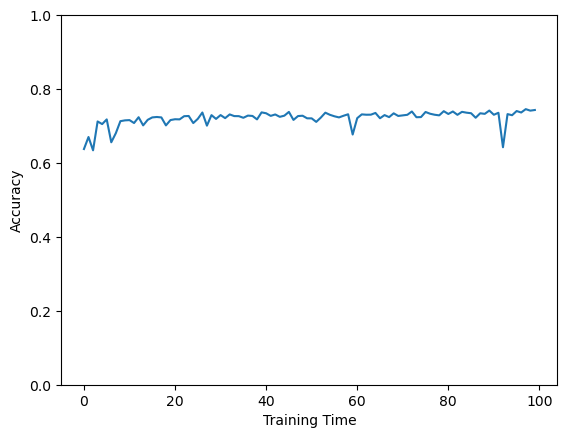

In [69]:
plt.plot(averageAccuracy(TrainAcc,datasetG))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [70]:
FinalAccuracy(TrainAcc,datasetG)

{'red1': 0.7311392405063292,
 'red0': 0.7425024582104228,
 'nonRed1': 0.7497762434471296,
 'nonRed0': 0.7335589941972921,
 'WorstAcc': 0.7311392405063292,
 'AvgAcc': 0.7433}

Processing model 10 / 100
Processing model 20 / 100
Processing model 30 / 100
Processing model 40 / 100
Processing model 50 / 100
Processing model 60 / 100
Processing model 70 / 100
Processing model 80 / 100
Processing model 90 / 100
Processing model 100 / 100


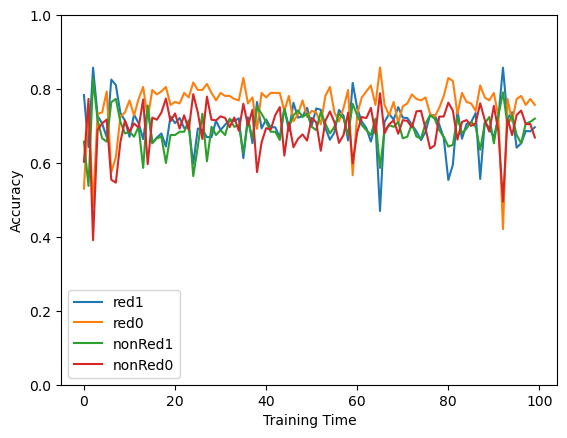

In [71]:
test1Acc = ModelListAccuracy(modelList, test1G)
plt.plot(test1Acc['red1'],label='red1')
plt.plot(test1Acc['red0'],label='red0')
plt.plot(test1Acc['nonRed1'],label='nonRed1')
plt.plot(test1Acc['nonRed0'],label='nonRed0')
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")
plt.legend()

Text(0, 0.5, 'Accuracy')

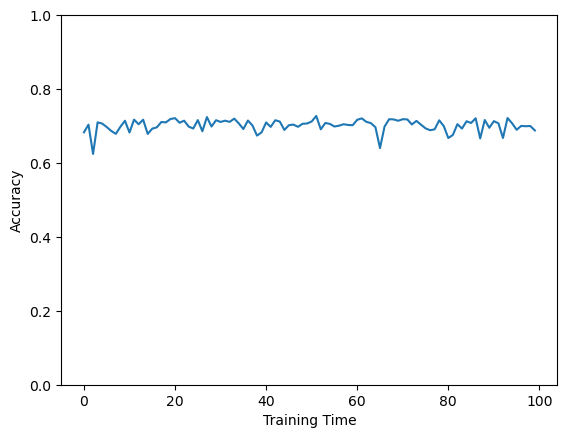

In [72]:
plt.plot(averageAccuracy(test1Acc,test1G))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [73]:
FinalAccuracy(test1Acc,test1G)

{'red1': 0.6966993755575379,
 'red0': 0.757085020242915,
 'nonRed1': 0.72,
 'nonRed0': 0.6688538932633421,
 'WorstAcc': 0.6688538932633421,
 'AvgAcc': 0.7274967421345543}

Colored MNIST dataset already exists


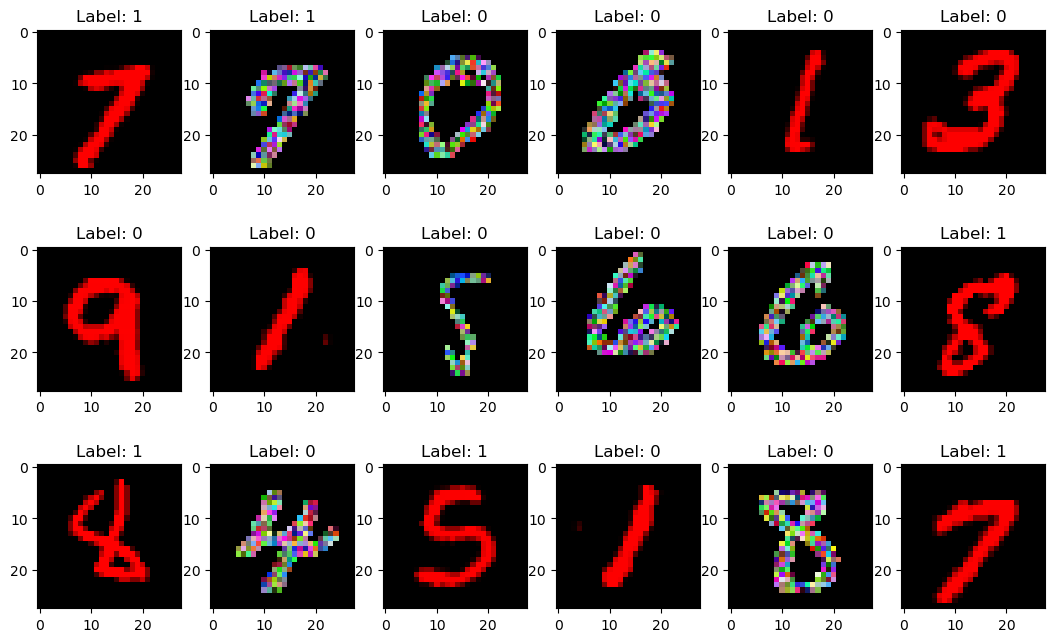

In [74]:
test2=ColoredMNIST(sampleSize=5000,startFrom=40000,flipColor=.5, nonRed='random')
plot_dataset_digits(test2) 

In [75]:
test2=ColoredMNIST(sampleSize=5000,flipColor=.5, nonRed='random',startFrom=40000,
    transform=transforms.ToTensor(),
    target_transform = lambda tar: torch.tensor([float(tar)]))
test2G=datasetInGroups(test2)
for d in test2G:
    print(d,len(test2G[d]))

Colored MNIST dataset already exists
red1 1201
red0 1242
nonRed1 1275
nonRed0 1282


Processing model 10 / 100
Processing model 20 / 100
Processing model 30 / 100
Processing model 40 / 100
Processing model 50 / 100
Processing model 60 / 100
Processing model 70 / 100
Processing model 80 / 100
Processing model 90 / 100
Processing model 100 / 100


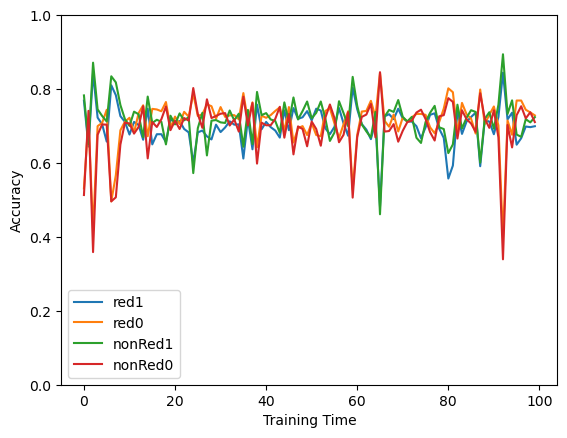

In [76]:
test2Acc = ModelListAccuracy(modelList, test2G)
plt.plot(test2Acc['red1'],label='red1')
plt.plot(test2Acc['red0'],label='red0')
plt.plot(test2Acc['nonRed1'],label='nonRed1')
plt.plot(test2Acc['nonRed0'],label='nonRed0')
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")
plt.legend()

Text(0, 0.5, 'Accuracy')

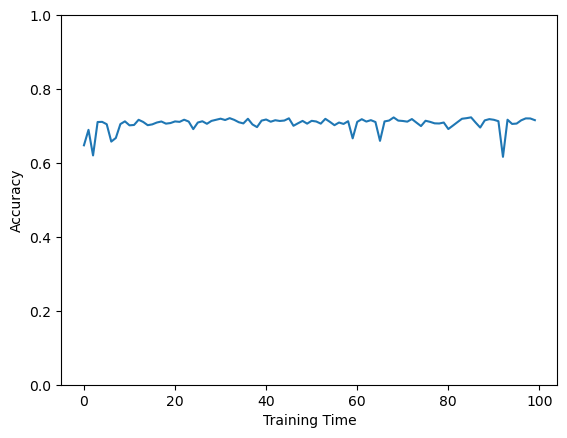

In [77]:
plt.plot(averageAccuracy(test2Acc,test2G))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [78]:
FinalAccuracy(test2Acc,test2G)

{'red1': 0.6994171523730225,
 'red0': 0.7286634460547504,
 'nonRed1': 0.7239215686274509,
 'nonRed0': 0.7106084243369735,
 'WorstAcc': 0.6994171523730225,
 'AvgAcc': 0.7220541741401162}

## DRO (Without regularization)

In [79]:
modelList2=train(datasetG,250000, storeModel=2500, l2_lambd=0)

Processing 5000/250000 loops
Processing 10000/250000 loops
Processing 15000/250000 loops
Processing 20000/250000 loops
Processing 25000/250000 loops
Processing 30000/250000 loops
Processing 35000/250000 loops
Processing 40000/250000 loops
Processing 45000/250000 loops
Processing 50000/250000 loops
Processing 55000/250000 loops
Processing 60000/250000 loops
Processing 65000/250000 loops
Processing 70000/250000 loops
Processing 75000/250000 loops
Processing 80000/250000 loops
Processing 85000/250000 loops
Processing 90000/250000 loops
Processing 95000/250000 loops
Processing 100000/250000 loops
Processing 105000/250000 loops
Processing 110000/250000 loops
Processing 115000/250000 loops
Processing 120000/250000 loops
Processing 125000/250000 loops
Processing 130000/250000 loops
Processing 135000/250000 loops
Processing 140000/250000 loops
Processing 145000/250000 loops
Processing 150000/250000 loops
Processing 155000/250000 loops
Processing 160000/250000 loops
Processing 165000/250000 loo

In [80]:
TrainAcc2 = ModelListAccuracy(modelList2, datasetG)

Processing model 10 / 100
Processing model 20 / 100
Processing model 30 / 100
Processing model 40 / 100
Processing model 50 / 100
Processing model 60 / 100
Processing model 70 / 100
Processing model 80 / 100
Processing model 90 / 100
Processing model 100 / 100


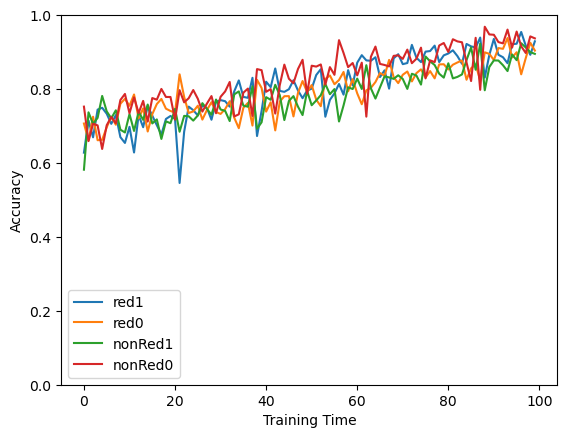

In [81]:
plt.plot(TrainAcc2['red1'],label='red1')
plt.plot(TrainAcc2['red0'],label='red0')
plt.plot(TrainAcc2['nonRed1'],label='nonRed1')
plt.plot(TrainAcc2['nonRed0'],label='nonRed0')
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")
plt.legend()

Text(0, 0.5, 'Accuracy')

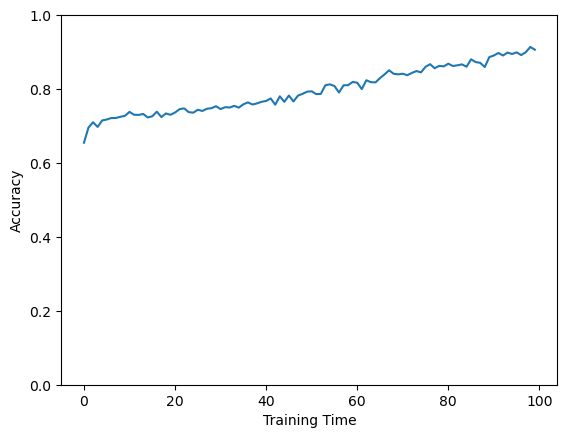

In [82]:
plt.plot(averageAccuracy(TrainAcc2,datasetG))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [83]:
FinalAccuracy(TrainAcc2,datasetG)

{'red1': 0.9291139240506329,
 'red0': 0.9040068829891839,
 'nonRed1': 0.8951540723692623,
 'nonRed0': 0.937137330754352,
 'WorstAcc': 0.8951540723692623,
 'AvgAcc': 0.90645}

In [84]:
test1Acc2 = ModelListAccuracy(modelList2, test1G)

Processing model 10 / 100
Processing model 20 / 100
Processing model 30 / 100
Processing model 40 / 100
Processing model 50 / 100
Processing model 60 / 100
Processing model 70 / 100
Processing model 80 / 100
Processing model 90 / 100
Processing model 100 / 100


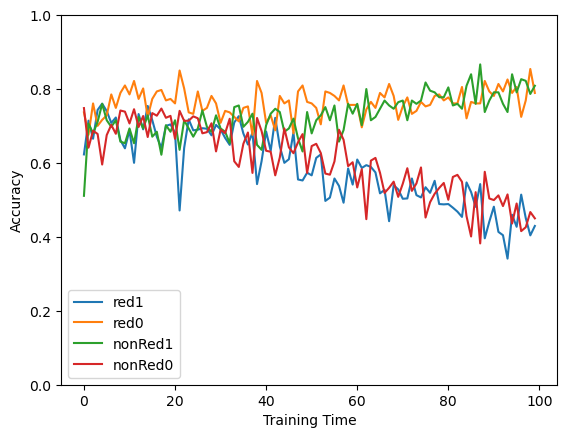

In [85]:
plt.plot(test1Acc2['red1'],label='red1')
plt.plot(test1Acc2['red0'],label='red0')
plt.plot(test1Acc2['nonRed1'],label='nonRed1')
plt.plot(test1Acc2['nonRed0'],label='nonRed0')
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")
plt.legend()

Text(0, 0.5, 'Accuracy')

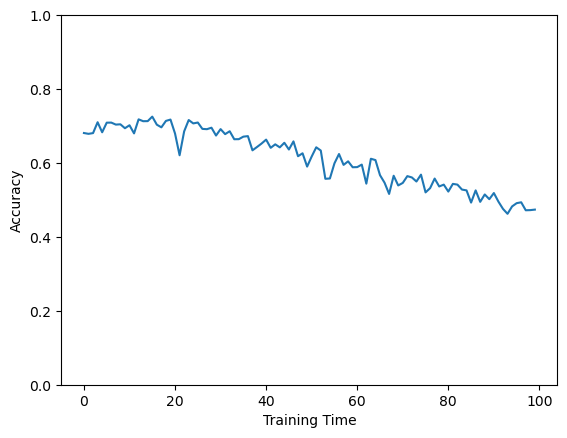

In [86]:
plt.plot(averageAccuracy(test1Acc2,test1G))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [87]:
FinalAccuracy(test1Acc2,test1G)

{'red1': 0.4295272078501338,
 'red0': 0.7894736842105263,
 'nonRed1': 0.8088888888888889,
 'nonRed0': 0.45013123359580054,
 'WorstAcc': 0.4295272078501338,
 'AvgAcc': 0.7264332760658486}

In [88]:
test2Acc2 = ModelListAccuracy(modelList2, test2G)

Processing model 10 / 100
Processing model 20 / 100
Processing model 30 / 100
Processing model 40 / 100
Processing model 50 / 100
Processing model 60 / 100
Processing model 70 / 100
Processing model 80 / 100
Processing model 90 / 100
Processing model 100 / 100


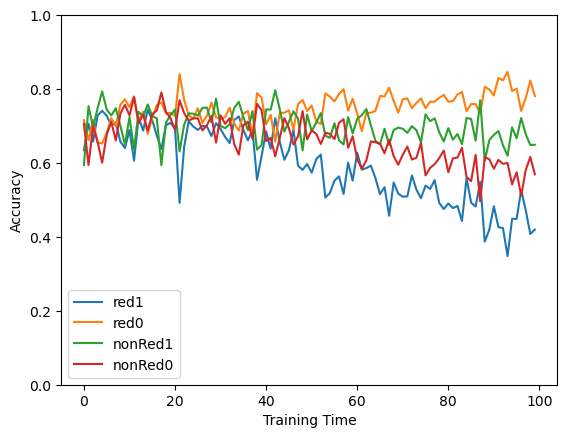

In [89]:
plt.plot(test2Acc2['red1'],label='red1')
plt.plot(test2Acc2['red0'],label='red0')
plt.plot(test2Acc2['nonRed1'],label='nonRed1')
plt.plot(test2Acc2['nonRed0'],label='nonRed0')
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")
plt.legend()

Text(0, 0.5, 'Accuracy')

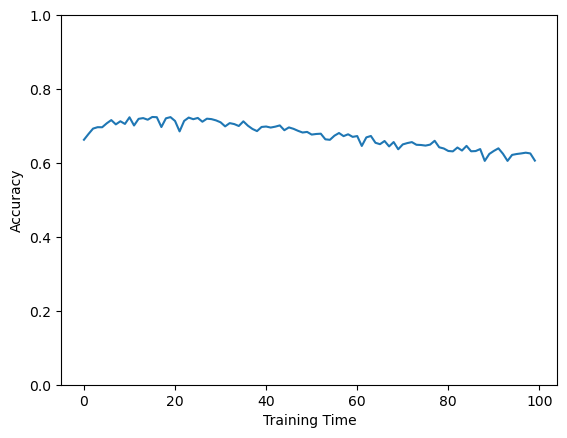

In [90]:
plt.plot(averageAccuracy(test2Acc2,test2G))
plt.ylim([0, 1])
plt.xlabel("Training Time")
plt.ylabel("Accuracy")

In [91]:
FinalAccuracy(test2Acc,test2G)

{'red1': 0.6994171523730225,
 'red0': 0.7286634460547504,
 'nonRed1': 0.7239215686274509,
 'nonRed0': 0.7106084243369735,
 'WorstAcc': 0.6994171523730225,
 'AvgAcc': 0.7220541741401162}